## Разведочный анализ данных(EDA)
#### Был проведен тщательный анализ данных, на основе которого планируется обучение модели рекомендательной системы постов для пользователей. В процессе анализа были проверены гипотезы и обнаружены явные закономерности в поведении пользователей.


In [1]:
import psycopg2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import random

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Выгрузка данныхс SQL-сервера

engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

df_user_data = pd.read_sql(
    """SELECT *
    FROM public.user_data
     """,
    con=engine
)

df_post_text_df = pd.read_sql(
    """SELECT *
    FROM public.post_text_df
     """,
    con=engine
)

#### Таблица user_data
##### Cодержит информацию о всех пользователях соц.сети

| Field name  | Overview                                                  |
|:------------|----------------------------------------------------------|
| age         | Возраст пользователя (в профиле)                           |
| city        | Город пользователя (в профиле)                             |
| country     | Страна пользователя (в профиле)                            |
| exp_group   | Экспериментальная группа: некоторая зашифрованная категория |
| gender      | Пол пользователя                                         |
| id          | Уникальный идентификатор пользователя                      |
| os          | Операционная система устройства, с которого происходит пользование соц.сетью |
| source      | Пришел ли пользователь в приложение с органического трафика или с рекламы |




In [10]:
df_user_data.head(2) 

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads


In [5]:
df_user_data.describe() ### Посмотрим на некатегориальные колонки

,user_id,gender,age,exp_group
count,163205.000000,163205.000000,163205.000000,163205.000000
mean,85070.371759,0.551331,27.195405,1.997598
std,48971.639950,0.497360,10.239158,1.413644
min,200.000000,0.000000,14.000000,0.000000
25%,41030.000000,0.000000,19.000000,1.000000
50%,85511.000000,1.000000,24.000000,2.000000
75%,127733.000000,1.000000,33.000000,3.000000
max,168552.000000,1.000000,95.000000,4.000000


In [15]:
df_user_data.info() # посмотрим есть ли пропущенные значения 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    163205 non-null  int64 
 1   gender     163205 non-null  int64 
 2   age        163205 non-null  int64 
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int64 
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int64(4), object(4)
memory usage: 10.0+ MB


#### Таблица post_text_df
##### Содержит информацию о постах и уникальный ID каждой единицы с соответствующим ей текстом и топиком

| Field name | Overview                                               |
|------------|-------------------------------------------------------|
| id         | Уникальный идентификатор поста                          |
| text       | Текстовое содержание поста                              |
| topic      | Основная тематика                                       |


In [11]:
df_post_text_df.head(2)

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business


In [8]:
df_post_text_df.describe() ### Посмотрим на некатегориальные колонки

,post_id
count,7023.000000
mean,3666.533817
std,2109.613383
min,1.000000
25%,1849.500000
50%,3668.000000
75%,5492.000000
max,7319.000000


### Таблица feed_data
##### Содержит историю о просмотренных постах для каждого юзера в изучаемый период.

#####  Таблица ОЧЕНЬ большая (78 млн строк). Ограничимся для анализа 1 млн строк. Решением такой проблемы является загрузка данных по кусочкам (или иначе говоря чанкам).
| Field name | Overview                                                     |
|------------|-------------------------------------------------------------|
| timestamp  | Время, когда был произведен просмотр                          |
| user_id    | id пользователя, который совершил просмотр                     |
| post_id    | id просмотренного поста                                       |
| action     | Тип действия: просмотр или лайк                               |
| target     | 1 у просмотров, если почти сразу после просмотра был совершен лайк, иначе 0. У действий like пропущенное значение. |


In [5]:
def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)


In [6]:
def load_liked_posts() -> pd.DataFrame:
    liked_posts_query = """
        SELECT *
        FROM public.feed_data
        LIMIT 1000000
        """
    liked_posts = batch_load_sql(liked_posts_query)
    return liked_posts
df_feed_data = load_liked_posts()

In [21]:
df_feed_data.head(2)

,timestamp,user_id,post_id,action,target
0,2021-12-18 13:50:49,150881,3940,view,0
1,2021-12-18 13:51:39,150881,4963,view,0


In [22]:
df_feed_data.describe() 

,user_id,post_id,target
count,1000000.000000,1000000.000000,1000000.000000
mean,110085.838358,3398.709981,0.105194
std,44042.518516,2095.463459,0.306803
min,29566.000000,1.000000,0.000000
25%,60499.000000,1527.000000,0.000000
50%,124455.000000,3196.000000,0.000000
75%,150886.000000,5209.000000,0.000000
max,164182.000000,7319.000000,1.000000


In [25]:
df_feed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1000000 non-null  datetime64[ns]
 1   user_id    1000000 non-null  int64         
 2   post_id    1000000 non-null  int64         
 3   action     1000000 non-null  object        
 4   target     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 38.1+ MB


##### В наших таблицах нет пропусков, перед тем как мерджить их, удалим из таблицы df_feed_data колонки action все значения где есть like, так как это информация дублируется в target

In [36]:
df_feed_data['action'].value_counts()

view    892242
like    107758
Name: action, dtype: int64

In [37]:
df_feed_data['target'].value_counts()

0    892244
1    107756
Name: target, dtype: int64

In [38]:
df_feed_data = df_feed_data[df_feed_data['action'] != 'like]
                            

,timestamp,user_id,post_id,action,target
0,2021-12-19 12:43:07,159776,123,view,0
1,2021-12-19 12:45:42,159776,1137,view,0
2,2021-12-19 12:46:33,159776,3825,view,0
3,2021-12-19 12:46:45,159776,6880,view,0
4,2021-12-19 12:49:18,159776,6504,view,0
...,...,...,...,...,...
999993,2021-12-23 18:46:27,127069,3540,view,0
999994,2021-12-23 18:49:26,127069,2356,view,1
999996,2021-12-23 18:51:54,127069,1771,view,0
999997,2021-12-23 18:54:34,127069,3847,view,0


In [40]:
# объединяем таблицы df_feed_data и df_user_data
df = pd.merge(
    df_feed_data,
    df_user_data,
    on='user_id',
    how='left'
)

df

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source
0,2021-12-19 12:43:07,159776,123,view,0,0,24,Russia,Apsheronsk,0,Android,organic
1,2021-12-19 12:45:42,159776,1137,view,0,0,24,Russia,Apsheronsk,0,Android,organic
2,2021-12-19 12:46:33,159776,3825,view,0,0,24,Russia,Apsheronsk,0,Android,organic
3,2021-12-19 12:46:45,159776,6880,view,0,0,24,Russia,Apsheronsk,0,Android,organic
4,2021-12-19 12:49:18,159776,6504,view,0,0,24,Russia,Apsheronsk,0,Android,organic
...,...,...,...,...,...,...,...,...,...,...,...,...
892237,2021-12-23 18:46:27,127069,3540,view,0,1,18,Russia,Saint Petersburg,2,Android,organic
892238,2021-12-23 18:49:26,127069,2356,view,1,1,18,Russia,Saint Petersburg,2,Android,organic
892239,2021-12-23 18:51:54,127069,1771,view,0,1,18,Russia,Saint Petersburg,2,Android,organic
892240,2021-12-23 18:54:34,127069,3847,view,0,1,18,Russia,Saint Petersburg,2,Android,organic


In [41]:
# объединяем таблицы df_feed_data и df_user_data
df = pd.merge(
    df,
    df_post_text_df,
    on='post_id',
    how='left'
)

df

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-12-19 12:43:07,159776,123,view,0,0,24,Russia,Apsheronsk,0,Android,organic,Circuit City gets takeover offer\n\nCircuit Ci...,business
1,2021-12-19 12:45:42,159776,1137,view,0,0,24,Russia,Apsheronsk,0,Android,organic,Housing plans criticised by MPs\n\nIrreversibl...,politics
2,2021-12-19 12:46:33,159776,3825,view,0,0,24,Russia,Apsheronsk,0,Android,organic,Markets may seem calm. But as economic challen...,covid
3,2021-12-19 12:46:45,159776,6880,view,0,0,24,Russia,Apsheronsk,0,Android,organic,I rented the movie and liked it so much that I...,movie
4,2021-12-19 12:49:18,159776,6504,view,0,0,24,Russia,Apsheronsk,0,Android,organic,Jennifer Grey seems the unlikeliest of romanti...,movie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892237,2021-12-23 18:46:27,127069,3540,view,0,1,18,Russia,Saint Petersburg,2,Android,organic,Ken Walker helps keep the donors smiling behin...,covid
892238,2021-12-23 18:49:26,127069,2356,view,1,1,18,Russia,Saint Petersburg,2,Android,organic,"If this order is APPLICABLE for entire Assam, ...",covid
892239,2021-12-23 18:51:54,127069,1771,view,0,1,18,Russia,Saint Petersburg,2,Android,organic,Parry puts Gerrard above money\n\nListen to th...,sport
892240,2021-12-23 18:54:34,127069,3847,view,0,1,18,Russia,Saint Petersburg,2,Android,organic,The pro-vegan ads in L.A. blaming #covid19 on ...,covid


In [43]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [58]:
### Посмотрим на категориальные колонки

categorical_columns = df.loc[:, df.dtypes == object].columns
categorical_columns = categorical_columns.drop(['text','action'])

df.loc[:, df.dtypes == object].head(2)


,action,country,city,os,source,text,topic
0,view,Russia,Apsheronsk,Android,organic,Circuit City gets takeover offer\n\nCircuit Ci...,business
1,view,Russia,Apsheronsk,Android,organic,Housing plans criticised by MPs\n\nIrreversibl...,politics


In [59]:
categorical_columns

Index(['country', 'city', 'os', 'source', 'topic'], dtype='object')

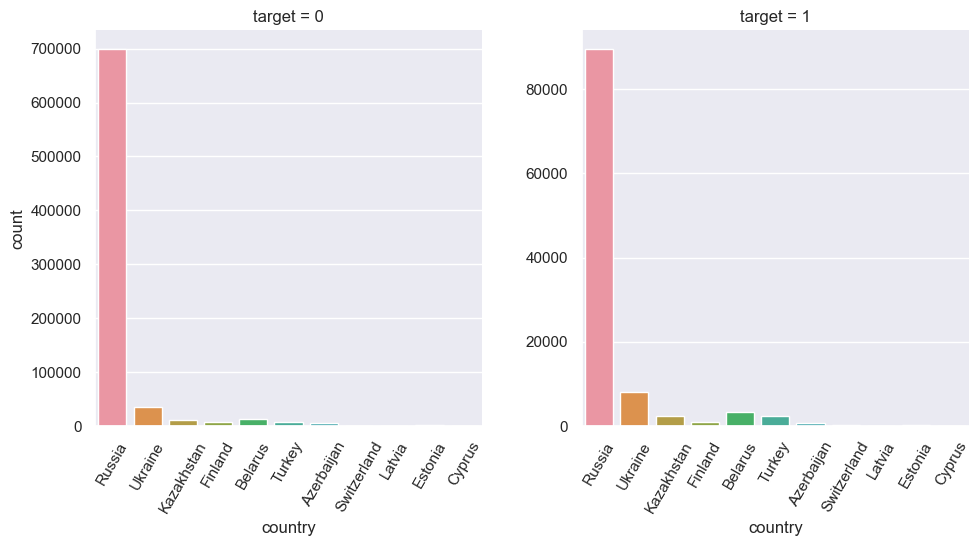

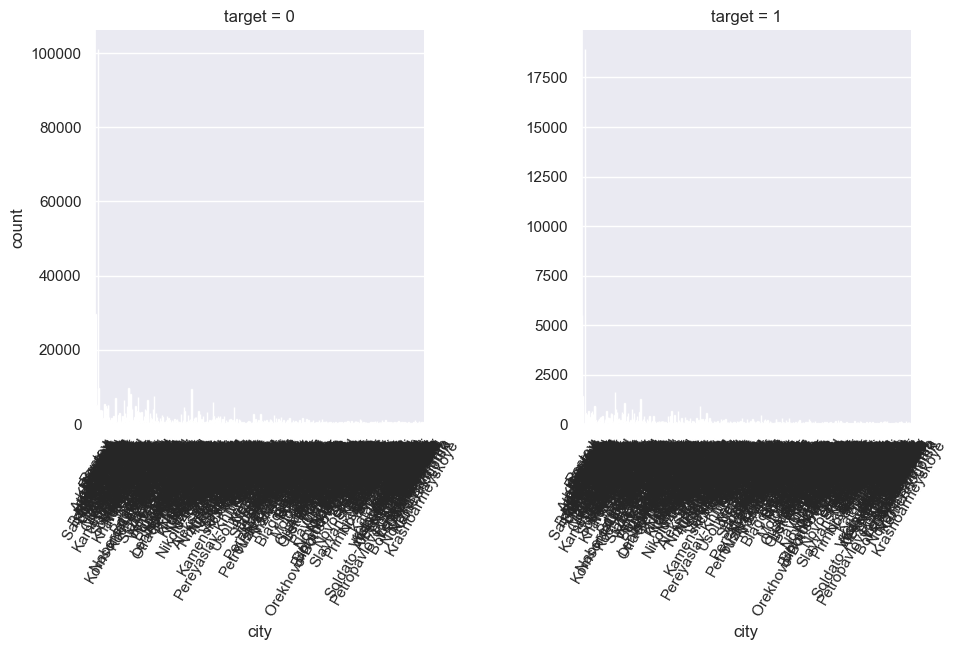

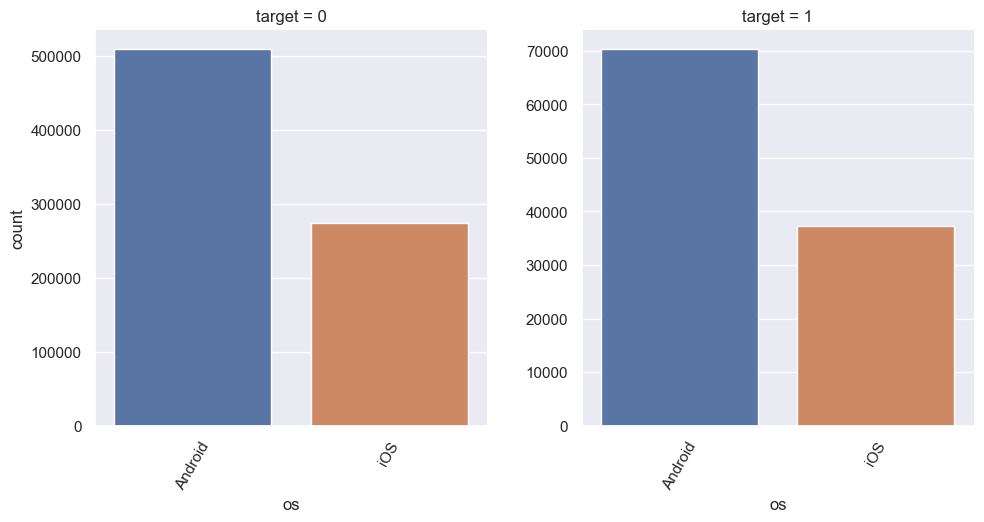

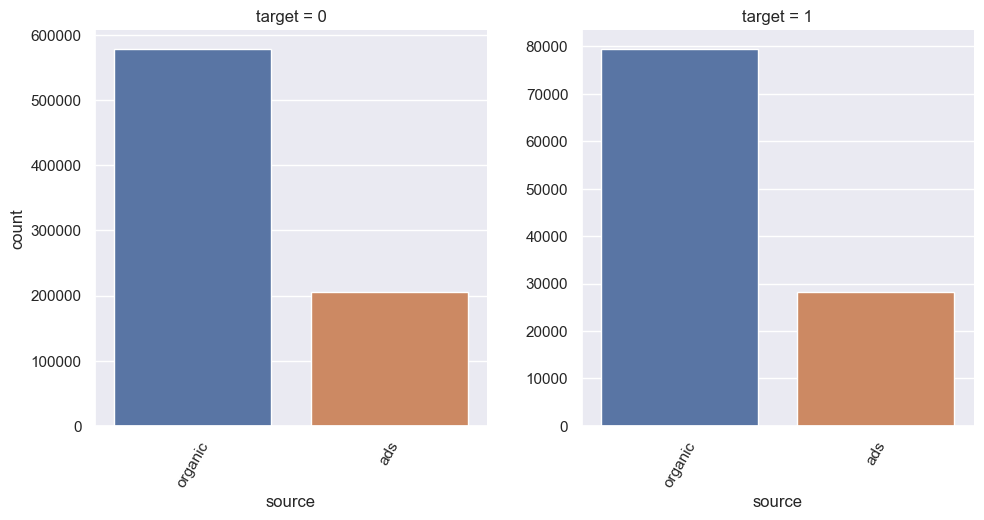

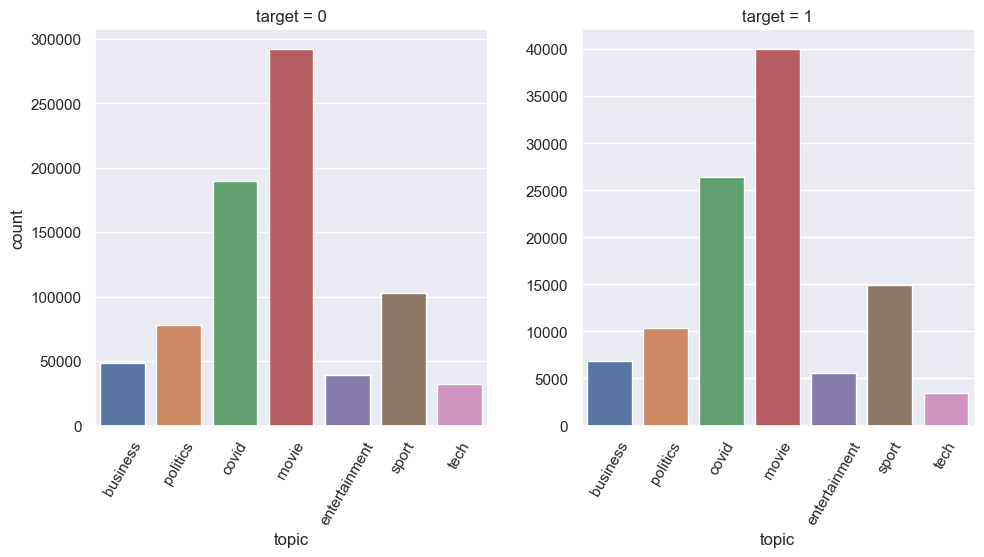

In [60]:
### Гистограммы распределений в разных классах 
sns.set(style="darkgrid")

for col in categorical_columns:
    g = sns.catplot(x=col, kind='count', col='target', data=df, sharey=False)
    g.set_xticklabels(rotation=60)
    plt.show()

#### Можем сделать вывод что топ-3 категории movie, covid и sport как по просмотрам так и по лайкам.

##### Посмотрим на поведение отдельных пользователей 

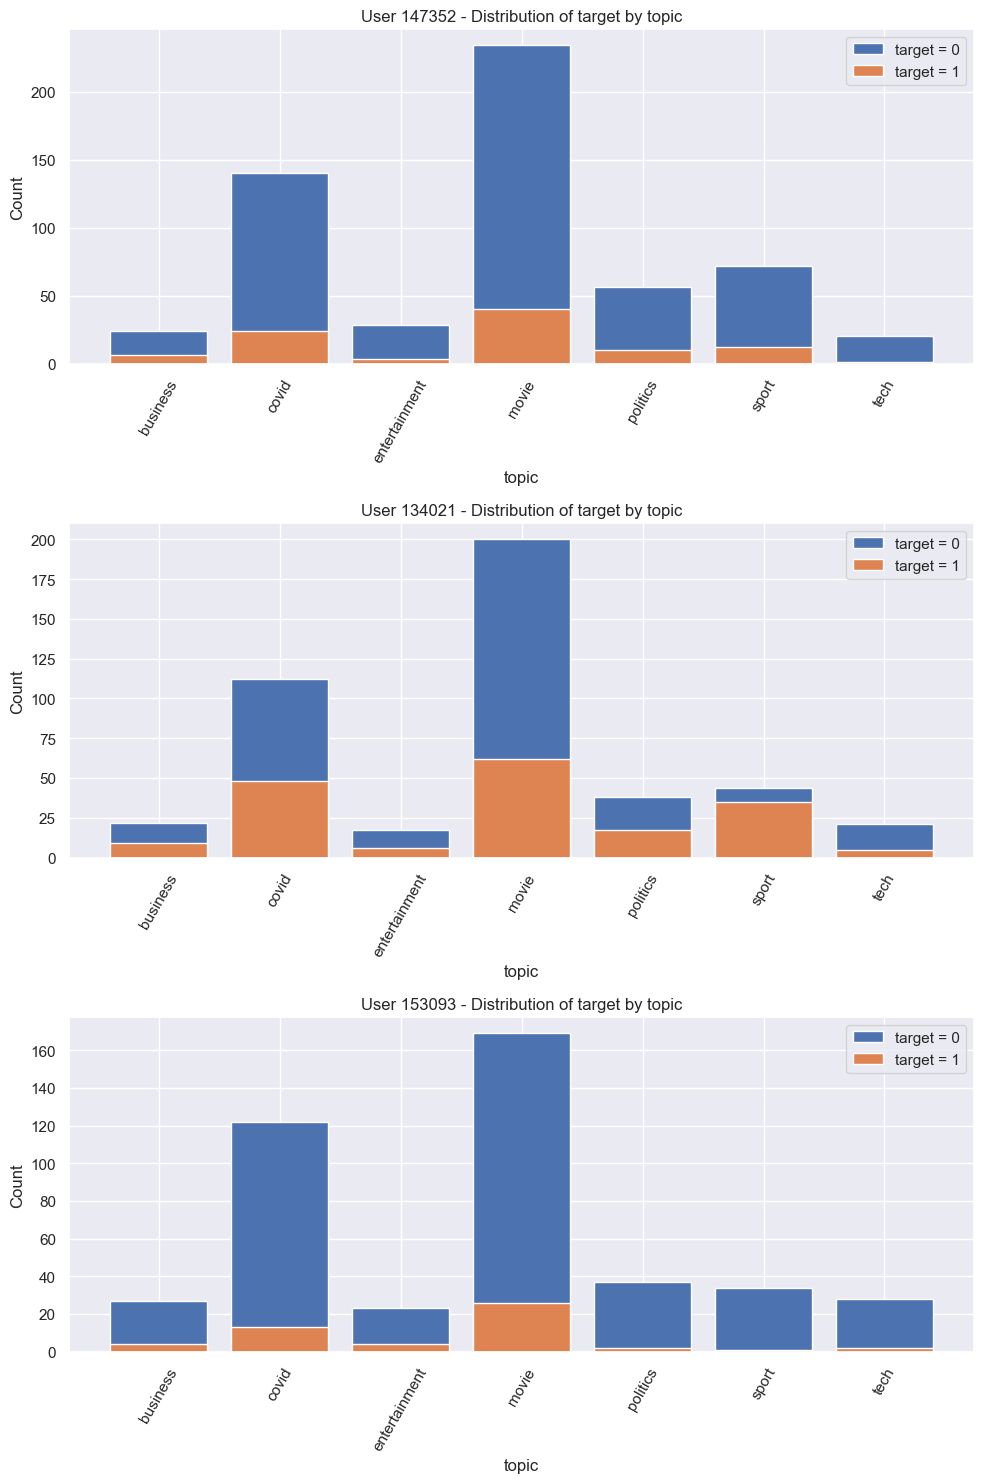

In [64]:
random_user_ids = random.sample(list(df['user_id'].unique()), 3)

fig, axes = plt.subplots(nrows=3, figsize=(10, 15))

for i, user_id in enumerate(random_user_ids):
    subset = df[df['user_id'] == user_id]
    count_target_0 = subset[subset['target'] == 0].groupby('topic').size()
    count_target_1 = subset[subset['target'] == 1].groupby('topic').size()

    ax = axes[i]
    ax.bar(count_target_0.index, count_target_0.values, label='target = 0')
    ax.bar(count_target_1.index, count_target_1.values, label='target = 1')
    ax.set_xlabel('topic')
    ax.set_ylabel('Count')
    ax.set_title(f"User {user_id} - Distribution of target by topic")
    ax.legend()
    ax.set_xticks(range(len(count_target_0.index)))
    ax.set_xticklabels(count_target_0.index, rotation=60)

plt.tight_layout()
plt.show()


#### Как мы можем наблюдать на примере 3 пользователей, у них есть явные предпочтения по категориям, обязательно используем это в модели рекомендаций

In [55]:
numeric_columns = df.loc[:,df.dtypes!=object].columns

df.loc[:,df.dtypes!=object].head(2)

,timestamp,user_id,post_id,target,gender,age,exp_group
0,2021-12-19 12:43:07,159776,123,0,0,24,0
1,2021-12-19 12:45:42,159776,1137,0,0,24,0


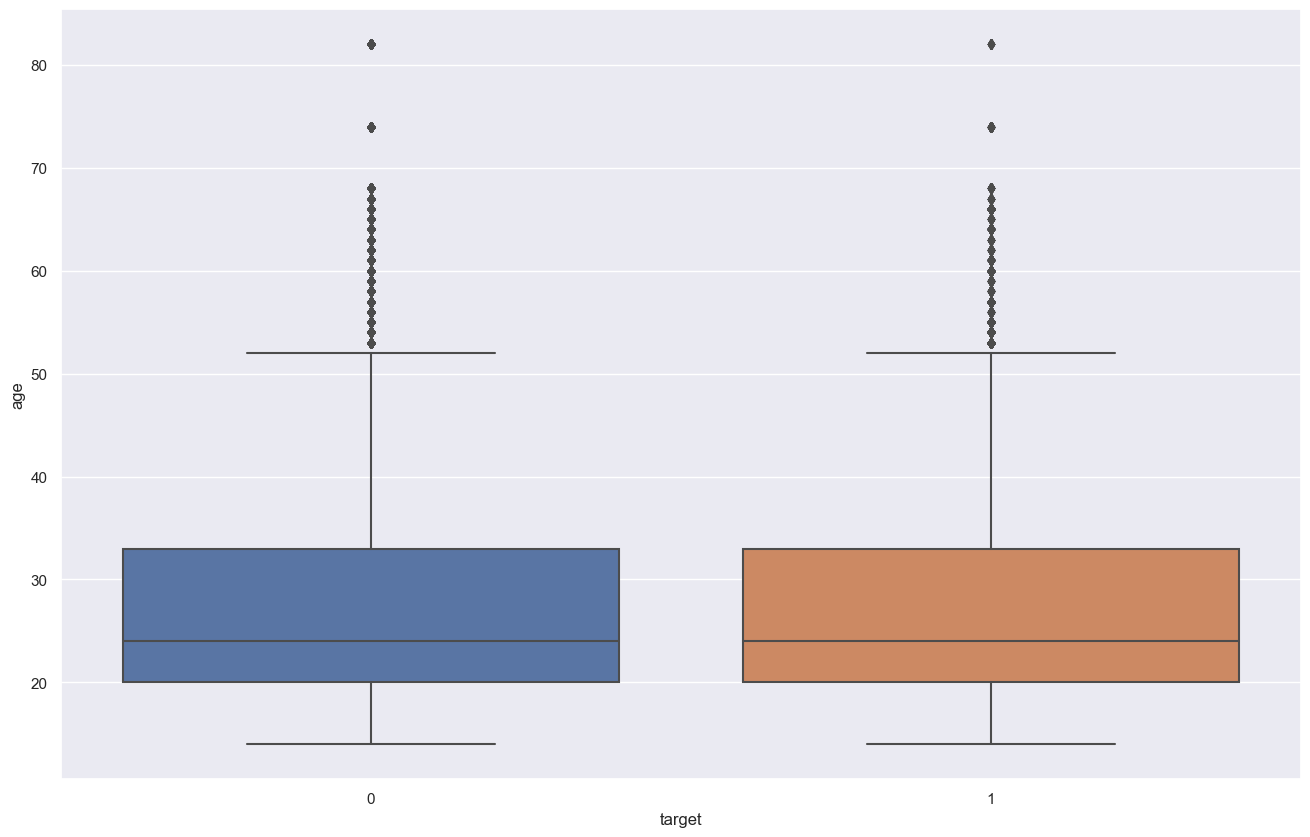

In [69]:
# Посмотрим на возраст наших пользователей, возможно будут отличия
   
fig = plt.figure()
fig.set_size_inches(16, 10)
sns.boxplot(y='age', x=df['target'].astype('category'), data=df)
plt.show()

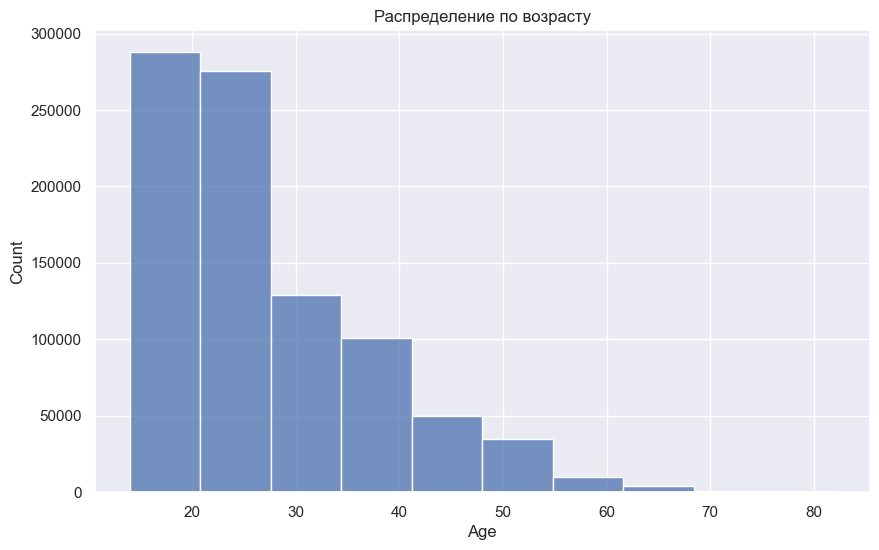

In [90]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Распределение по возрасту')
plt.show()


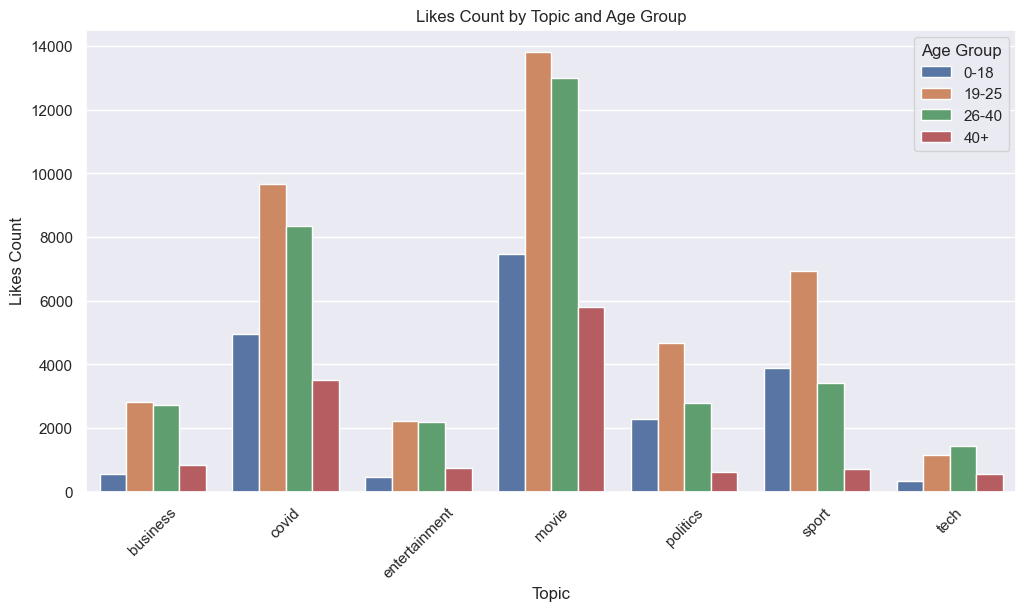

In [102]:
age_bins = [0, 18, 25, 40, float('inf')]
age_labels = ['0-18', '19-25', '26-40', '40+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

# Группировка по топикам и возрастным группам и подсчет количества значений target = 1
topic_age_likes = df[df['target'] == 1].groupby(['topic', 'age_group']).size().reset_index(name='likes_count')

plt.figure(figsize=(12, 6))
sns.barplot(x='topic', y='likes_count', hue='age_group', data=topic_age_likes)
plt.xlabel('Topic')
plt.ylabel('Likes Count')
plt.title('Likes Count by Topic and Age Group')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.show()


#### Анализируя взаимосвязь между возрастом и предпочтениями пользователей, мы видим интересные результаты. При рассмотрении второй по популярности категории, выделяется группа старшего поколения (40+), которая проявляет наибольший интерес к теме "covid" по сравнению с другими категориями. Более молодая категория (19-25) выделяется своим интересом к спорту и политике, и количество лайков по этим темам примерно в два раза больше, относительно других возрастных групп.

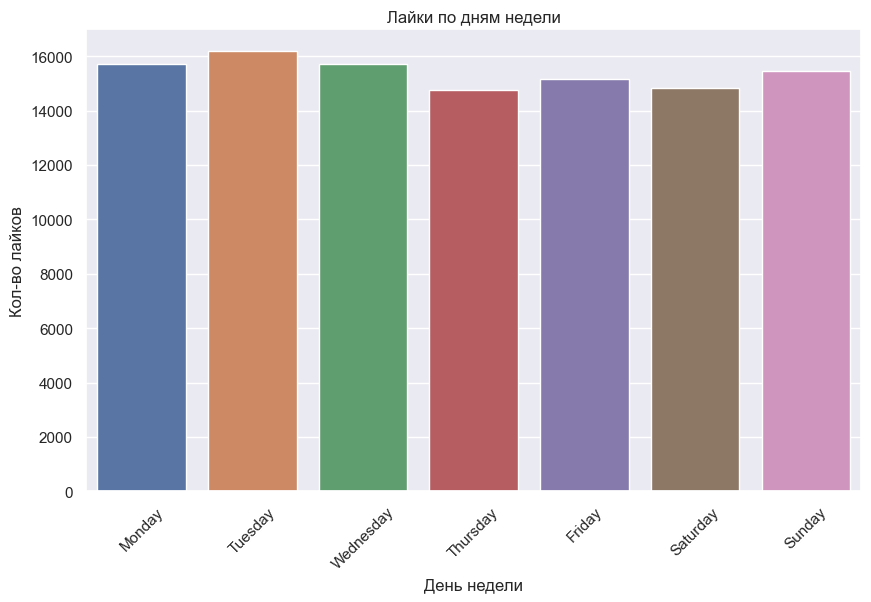

In [94]:
# Извлечение дня недели из столбца 'timestamp'
df['day_of_week'] = df['timestamp'].dt.day_name()

# Группировка по дню недели и подсчет количества лайков
likes_by_day = df.groupby('day_of_week')['target'].sum().reset_index()

# Установка порядка дней недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
likes_by_day['day_of_week'] = pd.Categorical(likes_by_day['day_of_week'], categories=days_order, ordered=True)

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='target', data=likes_by_day)
plt.xlabel('День недели')
plt.ylabel('Кол-во лайков')
plt.title('Лайки по дням недели')
plt.xticks(rotation=45)
plt.show()


#### Как мы видим на нашей выборке есть особенность, пользователи в начале недели проявляют чуть большую активность чем в конце недели. 

<Figure size 1200x600 with 0 Axes>

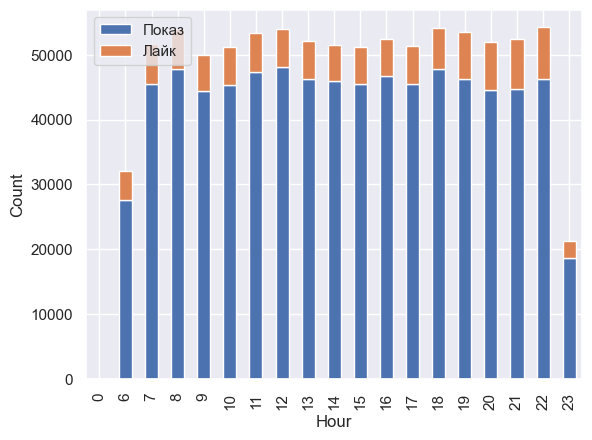

In [86]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

hourly_actions = df.groupby(['hour', 'target']).size().unstack()

plt.figure(figsize=(12, 6))
hourly_actions.plot(kind='bar', stacked=True)
plt.xlabel('Hour')
plt.ylabel('Count')
plt.legend(['Показ', 'Лайк'])
plt.show()

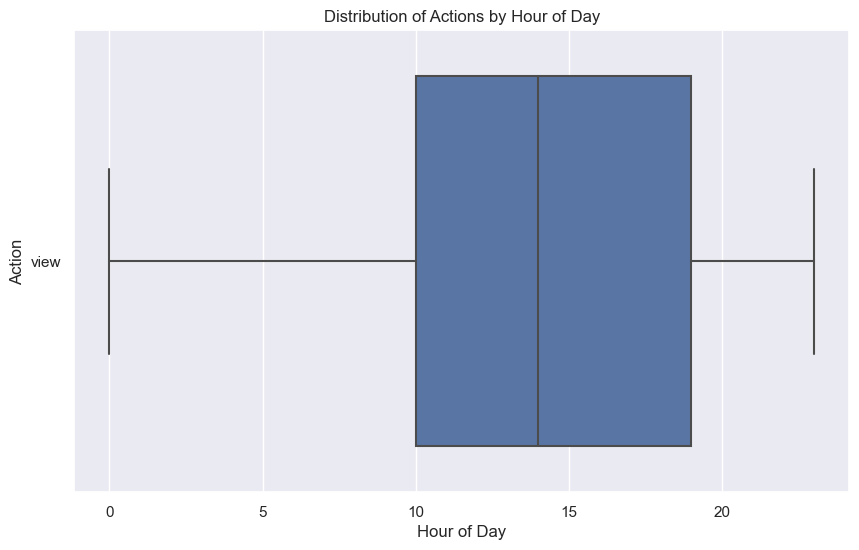

In [95]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour_of_day', y='action', data=df)
plt.xlabel('Hour of Day')
plt.ylabel('Action')
plt.title('Distribution of Actions by Hour of Day')
plt.show()


#### Обнаружено, что наименьшее количество просмотров и лайков приходится на ночные часы. Интерквантильный размах наблюдается в промежутке между 10:00 и 19:00 часами, что указывает на более активное взаимодействие пользователей в этот период времени.